In [8]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint

import numpy as np
import random
import sys
import os

In [2]:
import logging

log = logging.getLogger(sys.argv[0])
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s : %(processName)s : %(levelname)s : %(name)s : %(message)s")

log.info("Performing %s", 'TEST')

2018-03-19 23:41:31,705 : MainProcess : INFO : /Users/manuel/miniconda3/envs/wordgen-explore/lib/python3.6/site-packages/ipykernel_launcher.py : Performing TEST


In [3]:
path = "../datasets/i_malavoglia_short.txt"
saves_folder = "saves/"

try: 
    text = open(path).read().lower()
except UnicodeDecodeError:
    import codecs
    text = codecs.open(path, encoding='utf-8').read().lower()

print('corpus length:', len(text))

chars = set(text)
words = set(open(path).read().lower().split())

print("chars:",type(chars))
print("words",type(words))
print("total number of unique words",len(words))
print("total number of unique chars", len(chars))


word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

print("word_indices", type(word_indices), "length:",len(word_indices) )
print("indices_words", type(indices_word), "length", len(indices_word))

maxlen = 30
step = 3
print("maxlen:",maxlen,"step:", step)
sentences = []
next_words = []
next_words= []
sentences1 = []
list_words = []

sentences2=[]
list_words=text.lower().split()

for i in range(0,len(list_words)-maxlen, step):
    sentences2 = ' '.join(list_words[i: i + maxlen])
    sentences.append(sentences2)
    next_words.append((list_words[i + maxlen]))
print('nb sequences(length of sentences):', len(sentences))
print("length of next_word",len(next_words))


corpus length: 18012
chars: <class 'set'>
words <class 'set'>
total number of unique words 1284
total number of unique chars 47
word_indices <class 'dict'> length: 1284
indices_words <class 'dict'> length 1284
maxlen: 30 step: 3
nb sequences(length of sentences): 1018
length of next_word 1018


In [4]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence.split()):
        #print(i,t,word)
        X[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

Vectorization...


In [5]:
#build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(words))))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(words)))
#model.add(Dense(1000))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Build model...


In [6]:
weight_file = saves_folder + 'weights.hdf5'

if os.path.isfile(weight_file):
    model.load_weights(weight_file)

In [9]:
# train the model

checkpoint_filepath = "saves/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X, y, batch_size=128, nb_epoch=20, callbacks=callbacks_list)
model.save_weights(weight_file, overwrite=True)

/Users/manuel/miniconda3/envs/wordgen-explore/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
1018/1018 [==============================] - 13s 13ms/step - loss: 8.4694

Epoch 00001: loss improved from inf to 8.46944, saving model to saves/weights-improvement-01-8.47.hdf5
Epoch 2/20
1018/1018 [==============================] - 14s 14ms/step - loss: 6.2362

Epoch 00002: loss improved from 8.46944 to 6.23616, saving model to saves/weights-improvement-02-6.24.hdf5
Epoch 3/20
1018/1018 [==============================] - 14s 14ms/step - loss: 6.0546

Epoch 00003: loss improved from 6.23616 to 6.05458, saving model to saves/weights-improvement-03-6.05.hdf5
Epoch 4/20
1018/1018 [==============================] - 15s 14ms/step - loss: 5.9921

Epoch 00004: loss improved from 6.05458 to 5.99213, saving model to saves/weights-improvement-04-5.99.hdf5
Epoch 5/20
1018/1018 [==============================] - 15s 14ms/step - loss: 5.9164

Epoch 00005: loss improved from 5.99213 to 5.91636, saving model to saves/weights-improvement-05-5.92.hdf5
Epoch 6/20
1018/1018 [=================

2018-03-19 23:49:29,517 : MainProcess : DEBUG : matplotlib.font_manager : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/manuel/miniconda3/envs/wordgen-explore/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-03-19 23:49:29,550 : MainProcess : DEBUG : matplotlib.font_manager : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/manuel/miniconda3/envs/wordgen-explore/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


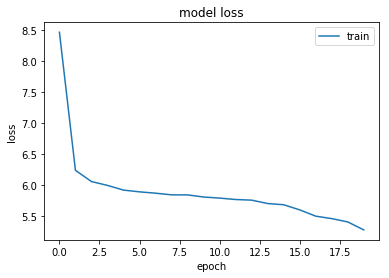

In [11]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [118]:
# train the model, output generated text after each iteration
#for iteration in range(1, 300):
#    print()
#    print('-' * 50)
#    print('Iteration', iteration)
#    history = model.fit(X, y, batch_size=128, nb_epoch=2)
#    model.save_weights(weight_file, overwrite=True)

### Sampling

In [12]:
# sample 20 experiment of rolling a dice, repeat for 10 times
np.random.multinomial(20, [1./6]*6, 10)

array([[2, 1, 4, 4, 3, 6],
       [2, 2, 1, 6, 4, 5],
       [8, 0, 3, 4, 1, 4],
       [0, 7, 2, 3, 3, 5],
       [3, 1, 1, 6, 2, 7],
       [5, 2, 1, 1, 4, 7],
       [6, 4, 0, 2, 3, 5],
       [7, 5, 0, 1, 4, 3],
       [2, 3, 5, 6, 1, 3],
       [3, 3, 3, 2, 7, 2]])

In [13]:
def sample_softmax(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [14]:
#def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#    a = np.log(a) / temperature
#    a = np.exp(a) / np.sum(np.exp(a))
#    return np.argmax(np.random.multinomial(1, a, 1))

*Temperature*. Play with the temperature of the Softmax during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes (e.g. spelling mistakes, etc).

In [15]:
# generate a sentence picked randomly in the text
def generate_seed_sentence(list_words, maxlen_seed):
    start_index = random.randint(0, len(list_words) - maxlen_seed - 1)
    sentence = list_words[start_index: start_index + maxlen_seed]
    #log.debug('Generating with seed: "%s"' , sentence)
    return sentence

# words: words in dict retrieved from training text
# sentence: seed sentence as a list of words
# temperature: parameter to tune for diversity of generated text
# maxlen_seed: max length of window to sample next words (seed sentences)
# maxlen_gen: max words to generate
def sample_words(words, sentence, temperature, maxlen_seed, maxlen_gen):
    generated = []
    for i in range(maxlen_gen):
        x = np.zeros((1, maxlen_seed, len(words)))
        for t, word in enumerate(sentence):
            x[0, t, word_indices[word]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample_softmax(preds, temperature)
        next_word = indices_word[next_index]
        
        del sentence[0]
        sentence.append(next_word)
        generated.append(next_word)
    
    return generated


In [16]:
sentence = generate_seed_sentence(list_words, maxlen)
result = sample_words(words, sentence, 0.8, maxlen, 100)
print("seed:")
print(' '.join(sentence))
print()
print("sampled:")
print(' '.join(result))

seed:
di le tramontana da gallina non gli quale non dice nonno, nipoti, figliuolo, campana a quegli e volta di non di e non pagò sentiva suo già! si aveva presto

sampled:
la a testa aveva prima e aveva aveva — quello per bisognava il la aveva la scarsa meglio non lisciato e sotto alla lo di in padron gran longa, reazionario — bene, a grattarsi che non segretario, se colle le e maggiore, le montagna in a non venti non scivolare al che per — baiocco. fatto papa udita, il lo il il sembrava campana che non — posati che che di le tramontana da gallina non gli quale non dice nonno, nipoti, figliuolo, campana a quegli e volta di non di e non pagò sentiva suo già! si aveva presto


In [115]:
# sampling at different diversities (== temperatures)

start_index = random.randint(0, len(list_words) - maxlen - 1)

for diversity in [0.2, 0.5, 1.0, 1.2]:
    sentence = generate_seed_sentence(list_words, maxlen)
    result = sample_words(words, sentence, diversity, maxlen, 100)
    print("----- diversity:", diversity)
    print("seed:")
    print(' '.join(sentence))
    print()
    print("sampled:")
    print(' '.join(result))

----- diversity: 0.2
seed:
che che che e che e che a che che che che che che che che che che che che il che che la che che che che che che

sampled:
la che e la che che e la e di e e e di di di che che che che che che che che che che che che e e che e che che che che che che che che che la che che che che che che e che che che che che che che che e che la che che che che che e che e che e che che che e che e che a che che che che che che che che che che che che il che che la che che che che che che
----- diversity: 0.5
seed:
— quelle di la e che della che gli se di animo di la il già! — il che a la la che e e la un non non per

sampled:
della che il — la il il quelle i e a e non della avevano il che e non che la di un un a e per che di che che che sul che di passo e che alla il e non la la il le un che e la non più. non che di la aveva di la e e le che che aiutarci. poi li il a la — quelle di la e che della che gli se di animo di la il già! — il che a la la che e e la un non non per
--